In [ ]:
# Imports
import pandas as pd
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, mean_absolute_error

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow.keras as keras



In [ ]:
# Load Dataset
dataset = pd.DataFrame(columns=['img_data', 'person_age', 'person_gender'])
idx = 0
from google.colab import files
import zipfile
import os
from PIL import Image

In [49]:

for file in os.listdir('UTKFace'):
    try:
        age, gender = map(int, file.split('_')[:2])
        img = Image.open(f'UTKFace/{file}').resize((110, 110))
        norm_img = np.array(img).astype(np.float32) / 255.0
        dataset.loc[idx] = [norm_img, age, gender]
        idx += 1
    except:
        continue

In [ ]:

# Shuffle the dataset
dataset = dataset.sample(frac=1).reset_index(drop=True)

1 0


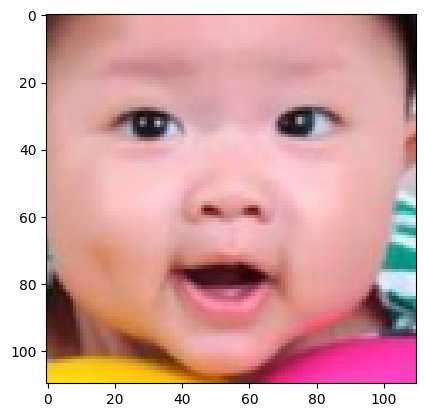

In [ ]:

#  Visual Check
plt.imshow(dataset['img_data'][0])
print(dataset['person_age'][0], dataset['person_gender'][0])

<Axes: xlabel='person_gender'>

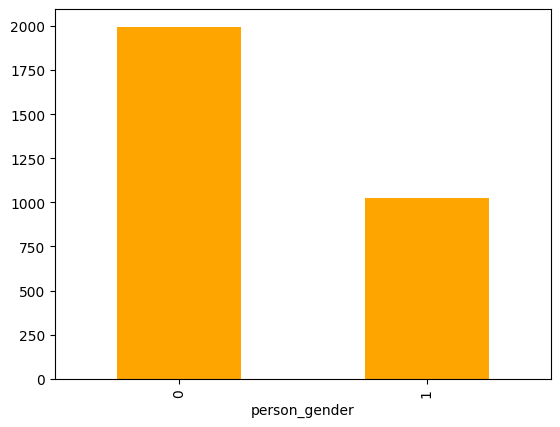

In [ ]:

#  Age and Gender Distribution
dataset['person_gender'].value_counts().plot(kind='bar', color='orange')

In [ ]:


#  Filter specific age range to reduce imbalance
target_ages = list(range(25, 35))
primary = dataset[(dataset['person_age'].isin(target_ages)) & (dataset['person_gender'].isin([0, 1]))]
others = dataset[~dataset.index.isin(primary.index)]
sampled_primary = primary.sample(frac=0.3).reset_index(drop=True)
final_data = pd.concat([others, sampled_primary], axis=0)

In [ ]:

#  Prepare Input/Output
images = np.stack(final_data['img_data'].values).reshape(-1, 110, 110, 3)
labels = np.stack([final_data['person_gender'].values, final_data['person_age'].values], axis=1)

In [55]:


x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)

y_train_split = [y_train[:, 0], y_train[:, 1]]
y_test_split = [y_test[:, 0], y_test[:, 1]]

In [ ]:

#  Build CNN Model
def build_cnn(input_shape=(110, 110, 3)):
    input_layer = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation='relu')(input_layer)
    x = MaxPool2D((2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPool2D((2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPool2D((2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)

    gender_output = Dense(1, activation='sigmoid', name='gender')(x)
    age_output = Dense(1, name='age')(x)

    model = Model(inputs=input_layer, outputs=[gender_output, age_output])
    model.compile(optimizer='adam', loss=["binary_crossentropy", "mae"], metrics=["accuracy", "mae"])
    return model

In [ ]:
#  Model Training
model = build_cnn()
model.summary()

callbacks = [
    ModelCheckpoint("Age_gender.keras", save_best_only=True, monitor='val_loss'),
    EarlyStopping(patience=20, monitor='val_loss', restore_best_weights=True)
]

history = model.fit(
    x_train, y_train_split,
    validation_data=(x_test, y_test_split),
    batch_size=14,
    epochs=200,
    shuffle=True,
    steps_per_epoch=len(x_train) // 18,
    callbacks=callbacks
)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 110, 110,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 108, 108,  │        896 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 54, 54,    │          0 │ conv2d_12[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        128 │ max_pooling2d_12… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 52, 52,    │     18,496 │ dropout_12[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 26, 26,    │          0 │ conv2d_13[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 26, 26,    │        256 │ max_pooling2d_13… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 26, 26,    │          0 │ batch_normalizat… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 24, 24,    │     73,856 │ dropout_13[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 12, 12,    │          0 │ conv2d_14[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │        512 │ max_pooling2d_14… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 12, 12,    │          0 │ batch_normalizat… │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 18432)     │          0 │ dropout_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 512)       │  9,437,696 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender (Dense)      │ (None, 1)         │        513 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age (Dense)         │ (None, 1)         │        513 │ batch_normalizat

 Total params: 9,534,914 (36.37 MB)

 Trainable params: 9,533,442 (36.37 MB)

 Non-trainable params: 1,472 (5.75 KB)

Epoch 1/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - age_loss: 5.8531 - age_mae: 5.8531 - gender_accuracy: 0.5414 - gender_loss: 1.1108 - loss: 6.9640 - val_age_loss: 4.5046 - val_age_mae: 4.5017 - val_gender_accuracy: 0.7273 - val_gender_loss: 0.6165 - val_loss: 5.1161
Epoch 2/200
27/89 ━━━━━━━━━━━━━━━━━━━━ 24s 390ms/step - age_loss: 4.3685 - age_mae: 4.3710 - gender_accuracy: 0.7327 - gender_loss: 0.5645 - loss: 4.9354

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - age_loss: 4.1379 - age_mae: 4.1871 - gender_accuracy: 0.6986 - gender_loss: 0.5980 - loss: 4.7831 - val_age_loss: 4.2152 - val_age_mae: 4.2108 - val_gender_accuracy: 0.7273 - val_gender_loss: 0.6018 - val_loss: 4.8105
Epoch 3/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - age_loss: 3.8702 - age_mae: 3.8702 - gender_accuracy: 0.7027 - gender_loss: 0.5859 - loss: 4.4561 - val_age_loss: 4.0361 - val_age_mae: 4.0334 - val_gender_accuracy: 0.7273 - val_gender_loss: 0.5726 - val_loss: 4.6051
Epoch 4/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - age_loss: 3.3103 - age_mae: 3.3310 - gender_accuracy: 0.7194 - gender_loss: 0.5660 - loss: 3.8966 - val_age_loss: 3.9930 - val_age_mae: 3.9906 - val_gender_accuracy: 0.7273 - val_gender_loss: 0.6620 - val_loss: 4.6504
Epoch 5/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - age_loss: 3.5336 - age_mae: 3.5336 - gender_accuracy: 0.7504 - gender_loss: 0.5113 - loss: 4.0448 - val_age_loss: 3.8015 - val_age_mae: 3.79

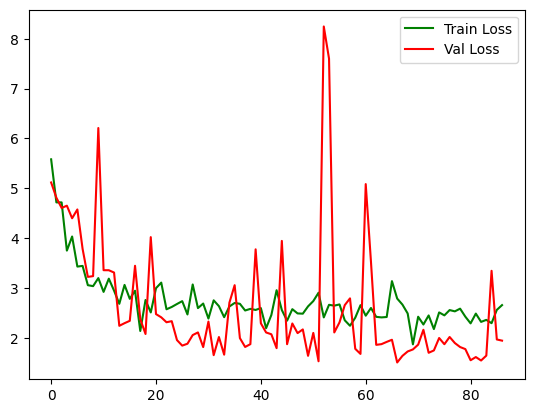

In [ ]:
#  Plot Loss
plt.plot(history.history['loss'], label='Train Loss', color='green')
plt.plot(history.history['val_loss'], label='Val Loss', color='red')
plt.legend()
plt.show()

In [ ]:


#  Evaluate
predictions = model.predict(x_test)
gender_pred = predictions[0]
age_pred = predictions[1]

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step


In [ ]:


print("📊 Gender Confusion Matrix:\n", confusion_matrix(y_test_split[0], gender_pred > 0.5))
print("✅ Accuracy:", accuracy_score(y_test_split[0], gender_pred > 0.5))
print("📉 Age MAE:", mean_absolute_error(y_test_split[1], np.round(age_pred)))
print("📉 Age MSE:", mean_squared_error(y_test_split[1], np.round(age_pred)))


📊 Gender Confusion Matrix:
 [[484  20]
 [ 25 164]]
✅ Accuracy: 0.935064935064935
📉 Age MAE: 1.1976912021636963
📉 Age MSE: 10.998557090759277


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
Age - Actual: 1 | Predicted: 1


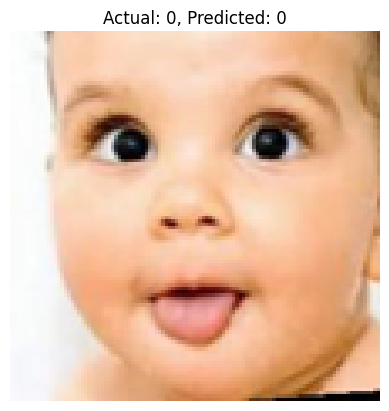

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Age - Actual: 1 | Predicted: 1


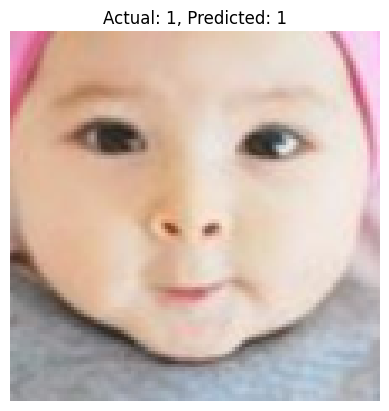

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Age - Actual: 1 | Predicted: 1


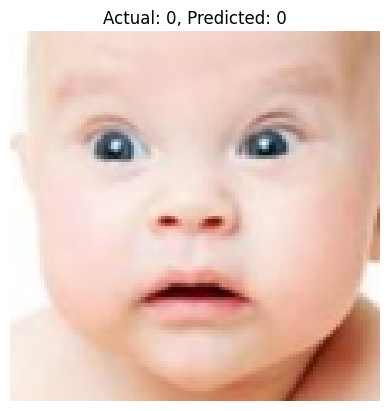

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Age - Actual: 1 | Predicted: 2


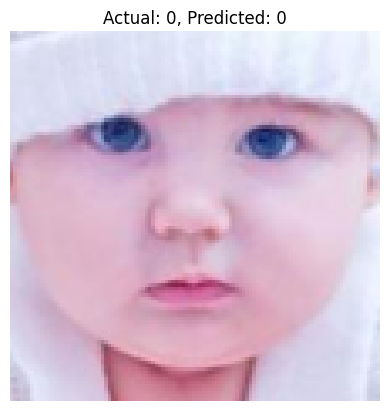

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Age - Actual: 1 | Predicted: 1


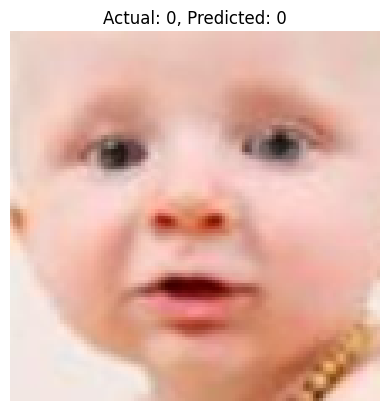

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Age - Actual: 1 | Predicted: 1


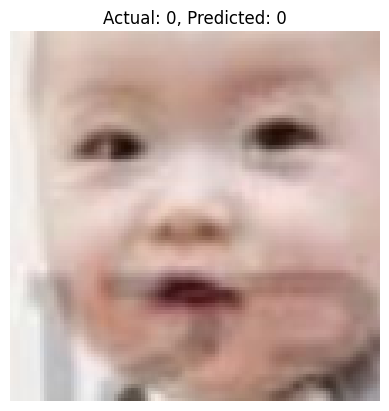

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Age - Actual: 1 | Predicted: 0


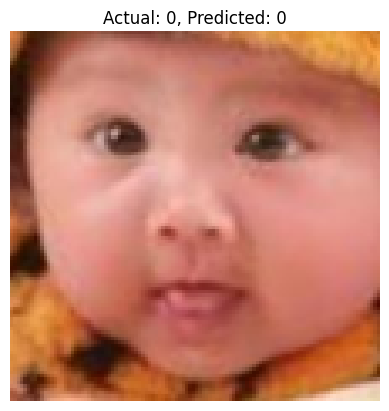

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Age - Actual: 1 | Predicted: 1


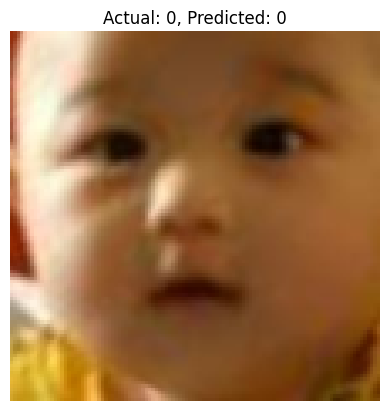

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Age - Actual: 31 | Predicted: 23


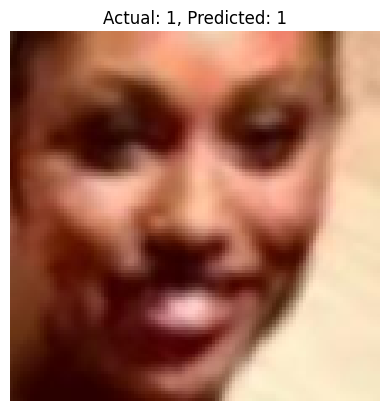

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Age - Actual: 1 | Predicted: 2


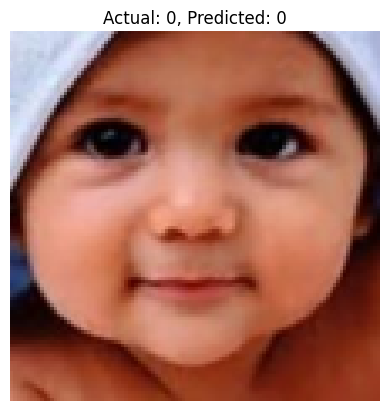

In [ ]:

#  Visual Output
for i in range(10):
    plt.imshow(x_test[i])
    pred = model.predict(np.expand_dims(x_test[i], axis=0))
    plt.title(f"Actual: {int(y_test_split[0][i])}, Predicted: {int(pred[0][0][0] > 0.5)}")
    print(f"Age - Actual: {y_test_split[1][i]} | Predicted: {round(pred[1][0][0])}")
    plt.axis('off')
    plt.show()